Data after loading:
        Date        Open        High         Low       Close   Adj Close  \
0  9/17/2014  465.864014  468.174011  452.421997  457.334015  457.334015   
1  9/18/2014  456.859985  456.859985  413.104004  424.440002  424.440002   
2  9/19/2014  424.102997  427.834991  384.532013  394.795990  394.795990   
3  9/20/2014  394.673004  423.295990  389.882996  408.903992  408.903992   
4  9/21/2014  408.084991  412.425995  393.181000  398.821014  398.821014   

       Volume  
0  21056800.0  
1  34483200.0  
2  37919700.0  
3  36863600.0  
4  26580100.0  
Data after date conversion:
        Date        Open        High         Low       Close   Adj Close  \
0 2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1 2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2 2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3 2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4 2014-09-21  408.0

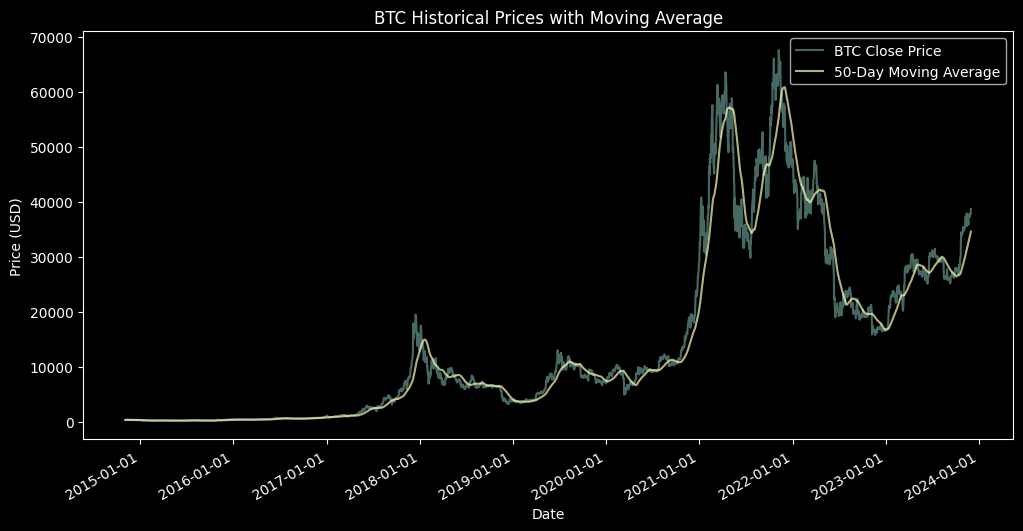

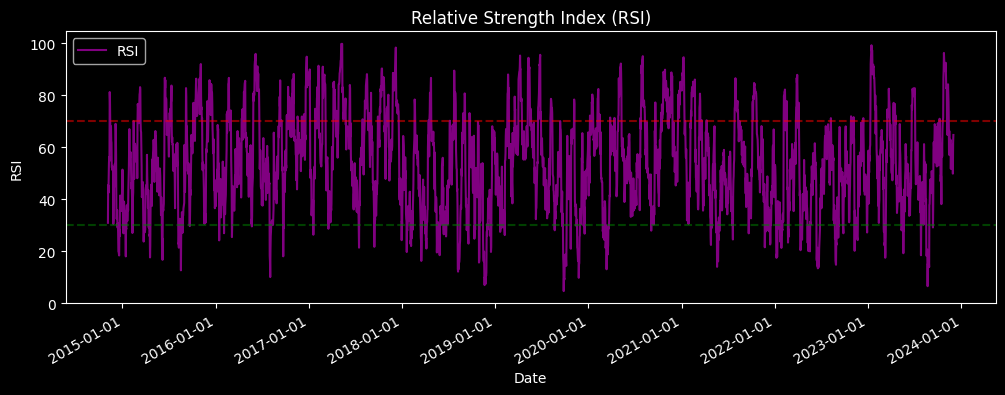

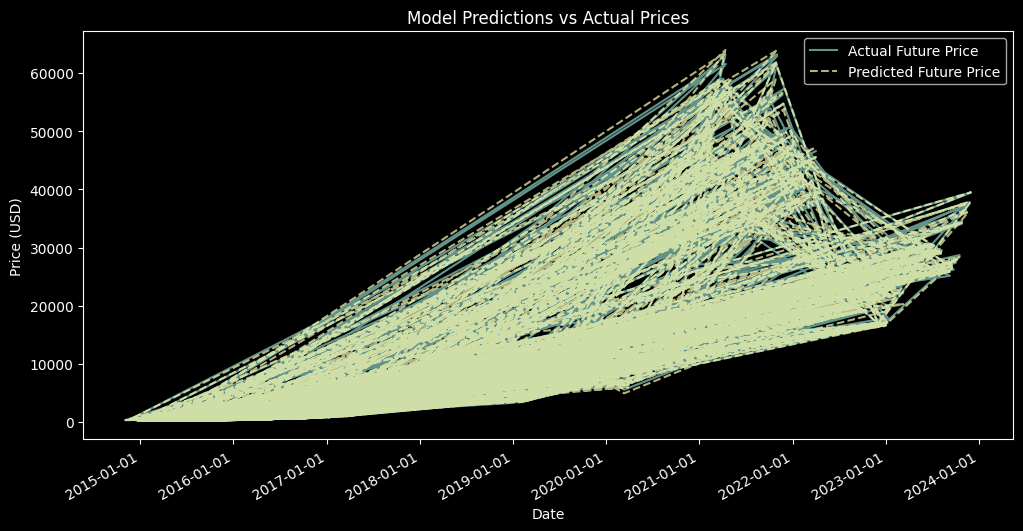

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import requests

# Define your API key
api_key = '17b993e3-1e66-445c-989b-7b6f6f12c046'

def get_current_btc_price(api_key):
    #  https://pro.coinmarketcap.com/account
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/quotes/latest'
    parameters = {
        'symbol': 'BTC',
        'convert': 'USD'
    }
    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': api_key,
    }
    response = requests.get(url, headers=headers, params=parameters)
    data = response.json()
    btc_price = data['data']['BTC']['quote']['USD']['price']
    return btc_price

def compute_rsi(data, window=14):
    delta = data.diff(1).dropna()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Load the new historical data
file_path = 'BTC-USD.csv'
historical_data = pd.read_csv(file_path)

#------------------------
# After loading the data
print("Data after loading:")
print(historical_data.head())

# After date conversion
historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%m/%d/%Y')
print("Data after date conversion:")
print(historical_data.head())

print("Data after numeric and float conversions:")
print(historical_data.head())
#------------------------

# Convert 'Date' column to datetime and set as index
historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%m/%d/%Y')
historical_data.set_index('Date', inplace=True)

# Convert 'Price' to numeric
historical_data['Close'] = historical_data['Close'].astype(str)  # Convert to string
historical_data['Price'] = pd.to_numeric(historical_data['Close'].str.replace(',', ''), errors='coerce')
# historical_data['Open'] = pd.to_numeric(historical_data['Open'].str.replace(',', ''), errors='coerce')
# historical_data['High'] = pd.to_numeric(historical_data['High'].str.replace(',', ''), errors='coerce')
# historical_data['Low'] = pd.to_numeric(historical_data['Low'].str.replace(',', ''), errors='coerce')

# Convert 'Vol.' to numeric (assuming 'K' stands for thousand)
historical_data['Volume'] = historical_data['Volume'].astype(str)  # Convert to string
historical_data['Volume'] = pd.to_numeric(historical_data['Volume'].str.replace(',', ''), errors='coerce') * 1000

# Calculate RSI and Moving Average
historical_data['RSI'] = compute_rsi(historical_data['Price'])
historical_data['Moving_Average'] = historical_data['Price'].rolling(window=50).mean()

# Drop rows with NaN values created by rolling function
historical_data.dropna(inplace=True)

# If historical_data is empty, raise an informative error
if historical_data.empty:
    raise ValueError('No data available after processing. Check data conversions and dropna operations.')

# Define a target variable for machine learning
historical_data['Future_Price'] = historical_data['Price'].shift(-1)
historical_data.dropna(inplace=True)

# Split data into features and target for machine learning
X = historical_data[['Price', 'Volume', 'Moving_Average', 'RSI']]
y = historical_data['Future_Price']

# Check if X or y are empty
if X.empty or y.empty:
    raise ValueError('Features (X) or target (y) are empty after processing. Check data integrity and target variable creation.')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Model training
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Model prediction
predictions = model.predict(X_test)

# Evaluate model (implement an evaluation metric)
print("Model Accuracy: ", model.score(X_test, y_test))

# Strategy implementation (simplified example)
def should_sell(current_price, ath_price, threshold=0.05):
    return current_price < ath_price * (1 - threshold)

# Example usage
current_price = get_current_btc_price(api_key)
ath_price = historical_data['Price'].max()

if should_sell(current_price, ath_price):
    print("It's time to sell")
else:
    print("Hold")

# Plotting
plt.style.use('dark_background')

# Plotting Price and Moving Average
plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data['Price'], label='BTC Close Price', alpha=0.5)
plt.plot(historical_data.index, historical_data['Moving_Average'], label='50-Day Moving Average', alpha=0.7)
plt.title('BTC Historical Prices with Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Auto-rotate dates
plt.show()

# Plotting RSI
plt.figure(figsize=(12, 4))
plt.plot(historical_data.index, historical_data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', alpha=0.5)  # Overbought line
plt.axhline(30, color='green', linestyle='--', alpha=0.5)  # Oversold line
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Auto-rotate dates
plt.show()

# Plotting Model Predictions vs Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Future Price', alpha=0.7)
plt.plot(y_test.index, predictions, label='Predicted Future Price', alpha=0.7, linestyle='--')
plt.title('Model Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Auto-rotate dates
plt.show()